<a href="https://colab.research.google.com/github/suchitrasundar/InteractiveMedia/blob/master/ClassificationOfFlowerImages.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tf-nightly-gpu
!pip install "tensorflow_hub==0.4.0"
!pip install -U tensorflow_datasets

     |████████████████████████████████| 370.5MB 51kB/s 
     |████████████████████████████████| 61kB 12.8MB/s 
     |████████████████████████████████| 501kB 34.9MB/s 
     |████████████████████████████████| 3.1MB 28.8MB/s 
     |████████████████████████████████| 686kB 6.5MB/s 


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
tf.enable_eager_execution()

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

W0613 06:06:05.781943 140402199353216 deprecation_wrapper.py:118] From /usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py:97: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0613 06:06:05.784111 140402199353216 deprecation_wrapper.py:118] From /usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py:97: The name tf.AttrValue is deprecated. Please use tf.compat.v1.AttrValue instead.

W0613 06:06:05.792737 140402199353216 deprecation_wrapper.py:118] From /usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py:97: The name tf.COMPILER_VERSION is deprecated. Please use tf.version.COMPILER_VERSION instead.

W0613 06:06:05.794686 140402199353216 deprecation_wrapper.py:118] From /usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py:97: The name tf.CXX11_ABI_FLAG is deprecated. Please use tf.sysconfig.CXX11_ABI_FLAG instead.

W0613 06:06:05.797705 140402199353216 deprecation_wrapper.py:118] From /usr/local/lib/python3.6/dist-pac

In [3]:
splits = tfds.Split.TRAIN.subsplit([70, 30])

(training_set, validation_set), dataset_info = tfds.load('tf_flowers', with_info=True, as_supervised=True, split=splits)

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/1.0.0. Subsequent calls will reuse this data.


In [4]:
num_classes = dataset_info.features['label'].num_classes

num_training_examples = 0
num_validation_examples = 0

for example in training_set:
  num_training_examples += 1
  
for example in validation_set:
  num_validation_examples += 1
  
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2590
Total Number of Validation Images: 1080 



In [5]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (335, 500, 3) label: 1
Image 2 shape: (333, 500, 3) label: 0
Image 3 shape: (240, 320, 3) label: 0
Image 4 shape: (240, 320, 3) label: 1
Image 5 shape: (333, 500, 3) label: 2


In [0]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

In [10]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model.compile(
  optimizer='adam', 
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 10

history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
81/81 [==============================] - 20s 243ms/step - loss: 0.3092 - acc: 0.9301 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
81/81 [==============================] - 13s 159ms/step - loss: 0.2743 - acc: 0.9475 - val_loss: 0.4467 - val_acc: 0.8657
Epoch 3/10
81/81 [==============================] - 13s 159ms/step - loss: 0.2514 - acc: 0.9571 - val_loss: 0.4486 - val_acc: 0.8676
Epoch 4/10
81/81 [==============================] - 13s 159ms/step - loss: 0.2324 - acc: 0.9649 - val_loss: 0.4517 - val_acc: 0.8704
Epoch 5/10
81/81 [==============================] - 13s 159ms/step - loss: 0.2162 - acc: 0.9730 - val_loss: 0.4554 - val_acc: 0.8667
Epoch 6/10
81/81 [==============================] - 13s 159ms/step - loss: 0.2024 - acc: 0.9799 - val_loss: 0.4594 - val_acc: 0.8667
Epoch 7/10
81/81 [==============================] - 13s 156ms/step - loss: 0.1905 - acc: 0.9853 - val_loss: 0.4634 - val_acc: 0.8667
Epoch 8/10
81/81 [==============================] - 13s 159ms

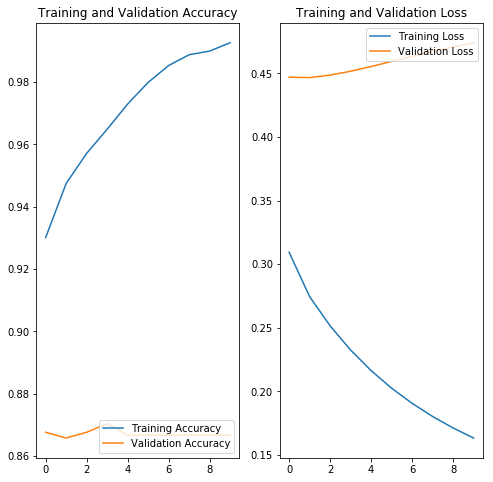

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [0]:
class_names = np.array(dataset_info.features['label'].names)

image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]


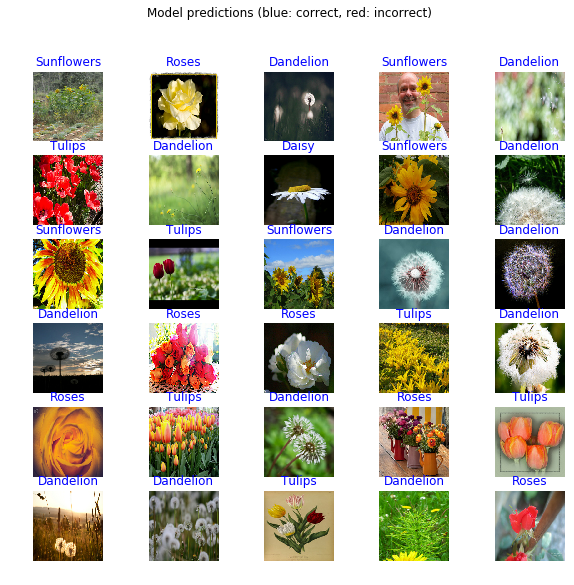

In [17]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")